# Multi-session analysis
This notebook demonstrate how to combine different xarray dataset together and perform group-level analysis

In [1]:
%reload_ext autoreload
%autoreload 2
import xarray as xr
import matplotlib.pylab as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import numpy as np
from glob import glob
import re
from datetime import datetime
from trialexp.process.folder_org.utils import build_session_info, load_and_concat_dataset, filter_sessions

## Build dataframe containing the metadata of all sessions

`build_session_info` will extract information from the by_sessions folder and build a dataframe for further filtering


In [80]:
#specify the location of the by_sessions folder here
root_path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions'

df_session_info = build_session_info(root_path, load_pycontrol=True, pycontrol_parameters=['hold_time_required_ms', 'US_delay_ms'], param_extract_method='tail')
df_session_info['hold_time_required_ms']=df_session_info['hold_time_required_ms'].astype(float)
df_session_info['US_delay_ms'] = df_session_info['US_delay_ms'].astype(float)

## Loading data

`filter_sessions` provide a set of functions for filtering recording sessions. For details on how to use it, please consult its documentation

In [84]:
#select the last 5 sessions from animal kms058
df_sel = filter_sessions(df_session_info,session_no=3, 
                         animal_id=['TT001', 'TT002','TT005', 'RE606','RE607'],
                         session_method='tail', 
                         task_name='reaching_go_spout_bar_nov22', 
                         query='hold_time_required_ms >= 1000 and US_delay_ms>=500')
df_sel.sort_values(['animal_id','expt_datetime'])

,animal_id,expt_datetime,session_id,task_name,path,session_no,US_delay_ms,hold_time_required_ms
241,RE606,2023-05-31 11:56:41,RE606-2023-05-31-115641,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,5.0,500.0,1000.0
232,RE606,2023-06-01 12:12:01,RE606-2023-06-01-121201,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,6.0,500.0,1000.0
185,RE606,2023-06-02 10:40:01,RE606-2023-06-02-104001,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,7.0,500.0,1000.0
291,RE607,2023-05-31 12:59:59,RE607-2023-05-31-125959,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,6.0,500.0,1000.0
233,TT001,2023-06-02 16:36:05,TT001-2023-06-02-163605,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,8.0,500.0,1000.0
277,TT002,2023-06-02 15:54:42,TT002-2023-06-02-155442,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,9.0,500.0,1000.0
254,TT005,2023-06-02 15:23:09,TT005-2023-06-02-152309,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,9.0,500.0,1000.0
353,TT005,2023-06-02 16:04:27,TT005-2023-06-02-160427,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,10.0,500.0,1000.0


`load_and_conat_dataset` is a helper functions that combines multiple sessions of dataset together

In [85]:
paths = df_sel.path
ds_combined = load_and_concat_dataset(paths)

  0%|          | 0/8 [00:00<?, ?it/s]

Concating datasets...


In [86]:
ds_combined

<xarray.Dataset>
Dimensions:                           (trial_nb: 508, event_time: 500,
                                       session_id: 8)
Coordinates:
  * trial_nb                          (trial_nb) int64 1 2 3 4 ... 506 507 508
  * event_time                        (event_time) float64 -1.995e+03 ... 2.9...
  * session_id                        (session_id) object 'RE606-2023-05-31-1...
Data variables: (12/21)
    uid                               (session_id, trial_nb) object 'RE606_20...
    trigger                           (session_id, trial_nb) object 'hold_for...
    valid                             (session_id, trial_nb) float64 1.0 ... nan
    Go_to_get_water                   (session_id, trial_nb) float64 0.0 ... nan
    US_end_timer                      (session_id, trial_nb) float64 0.0 ... nan
    break_after_abort                 (session_id, trial_nb) float64 1.0 ... nan
    ...                                ...
    success                           (session_id, trial_nb) float64 0.0 ... nan
    trial_outcome                     (session_id, trial_nb) object 'aborted'...
    hold_for_water_zscored_df_over_f  (session_id, trial_nb, event_time) float64 ...
    first_bar_off_zscored_df_over_f   (session_id, trial_nb, event_time) float64 ...
    first_spout_zscored_df_over_f     (session_id, trial_nb, event_time) float64 ...
    last_bar_off_zscored_df_over_f    (session_id, trial_nb, event_time) float64 ...

## Plot figures

In [ ]:
sns.set_context('talk',font_scale=0.8)

animal_id = df_sel[['animal_id','session_id']]

def plot_subject_average(ds_combined, animal_id, var_name):

    df2plot = ds_combined[[var_name, 'trial_outcome','session_id']].to_dataframe().reset_index()

    #only plot several outcomes
    sel_trial_outcome = ['success', 'aborted']
    df2plot = df2plot[df2plot.trial_outcome.isin(sel_trial_outcome)]


    #merge the animal_id back to the data frame
    df2plot = df2plot.merge(animal_id, on='session_id')

    g = sns.relplot(x='event_time',y=var_name, hue='animal_id',
                col='trial_outcome', col_wrap=3, kind='line', n_boot=100, data=df2plot)
    
    g.set_xlim([-1000, 1500])
    
    
plot_subject_average(ds_combined, animal_id, 'hold_for_water_zscored_df_over_f')

<Axes: xlabel='event_time', ylabel='hold_for_water_zscored_df_over_f'>

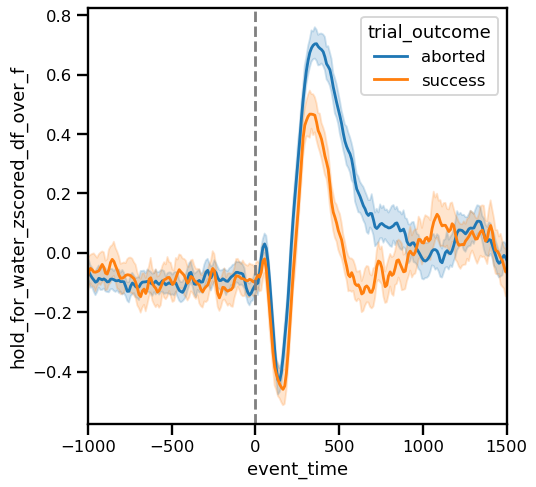

In [125]:
def plot_group_average(ds_combined, animal_id, var_name):
    fig, ax = plt.subplots(1,1,dpi=90, figsize=(6,6))
    df2plot = ds_combined[[var_name, 'trial_outcome','session_id']].to_dataframe().reset_index()

    #only plot several outcomes
    sel_trial_outcome = ['success', 'aborted']
    df2plot = df2plot[df2plot.trial_outcome.isin(sel_trial_outcome)]


    #merge the animal_id back to the data frame
    df2plot = df2plot.merge(animal_id, on='session_id')

    ax = sns.lineplot(x='event_time',y=var_name, hue='trial_outcome', n_boot=100, data=df2plot, ax=ax)
    ax.axvline(0,ls='--',color='gray')
    ax.set_xlim([-1000,1500])
    
    return ax
    
plot_group_average(ds_combined, animal_id, 'hold_for_water_zscored_df_over_f')

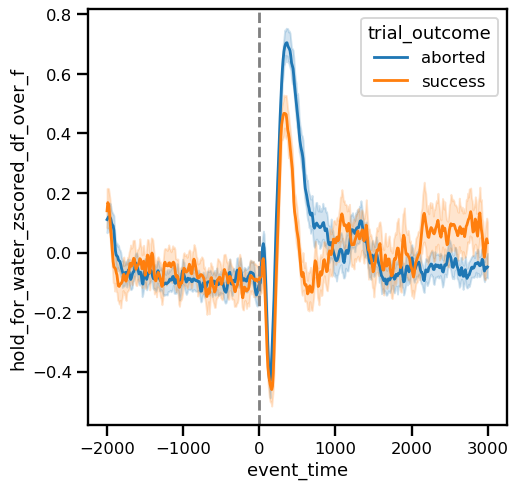

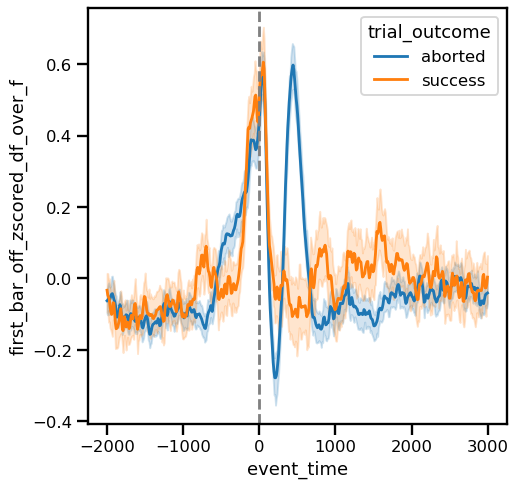

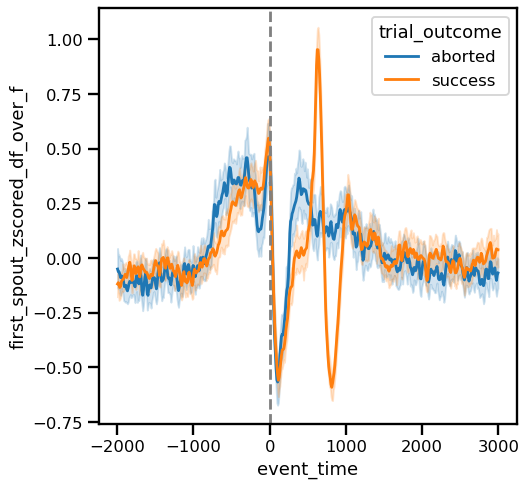

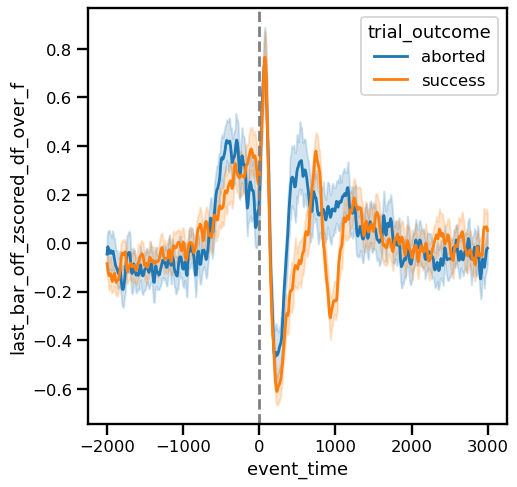

In [123]:
vars_to_plot = ['hold_for_water_zscored_df_over_f', 
                'first_bar_off_zscored_df_over_f',
                'first_spout_zscored_df_over_f',
                'last_bar_off_zscored_df_over_f']

for v in vars_to_plot:
    plot_group_average(ds_combined, animal_id, v)

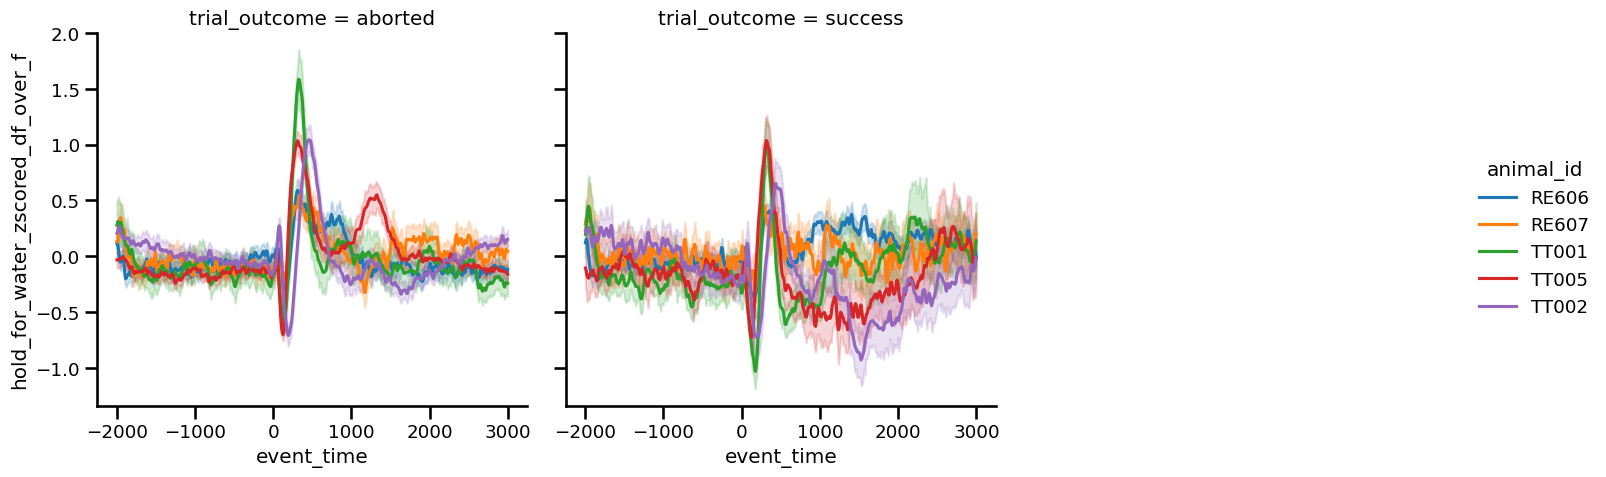

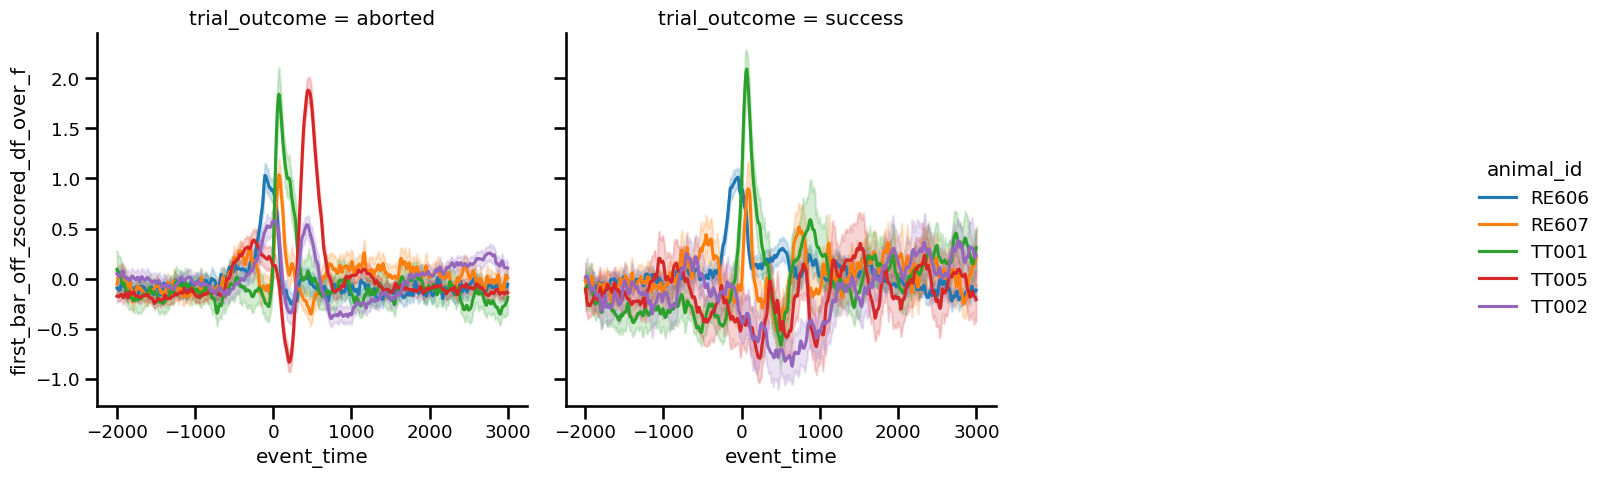

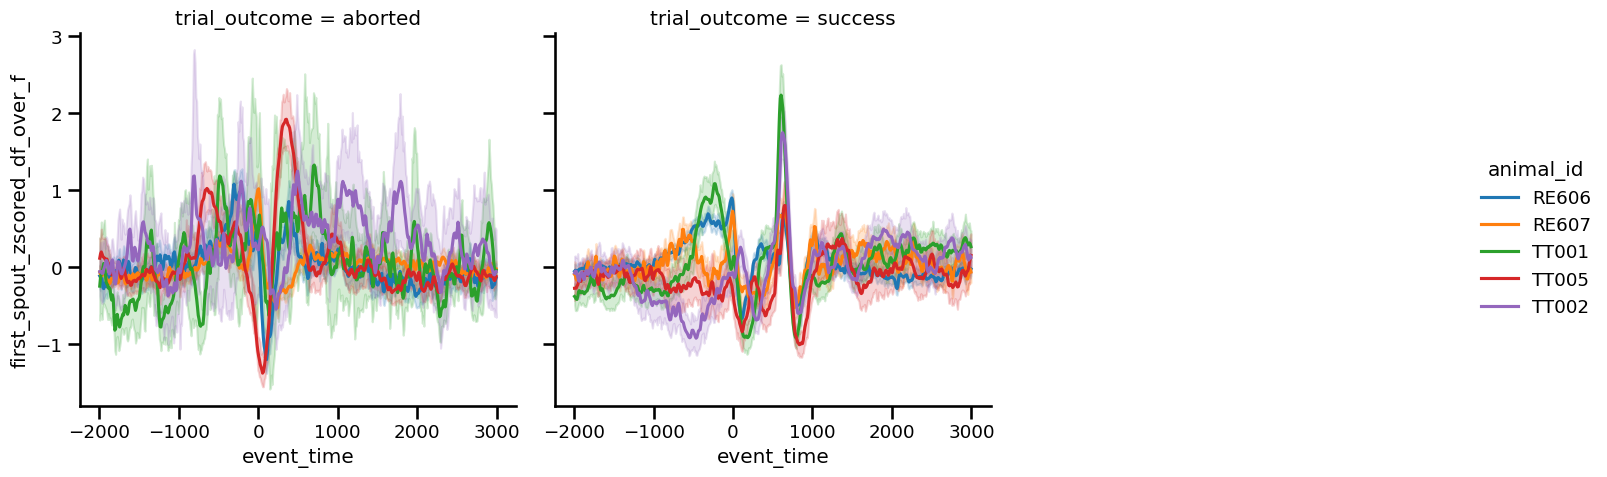

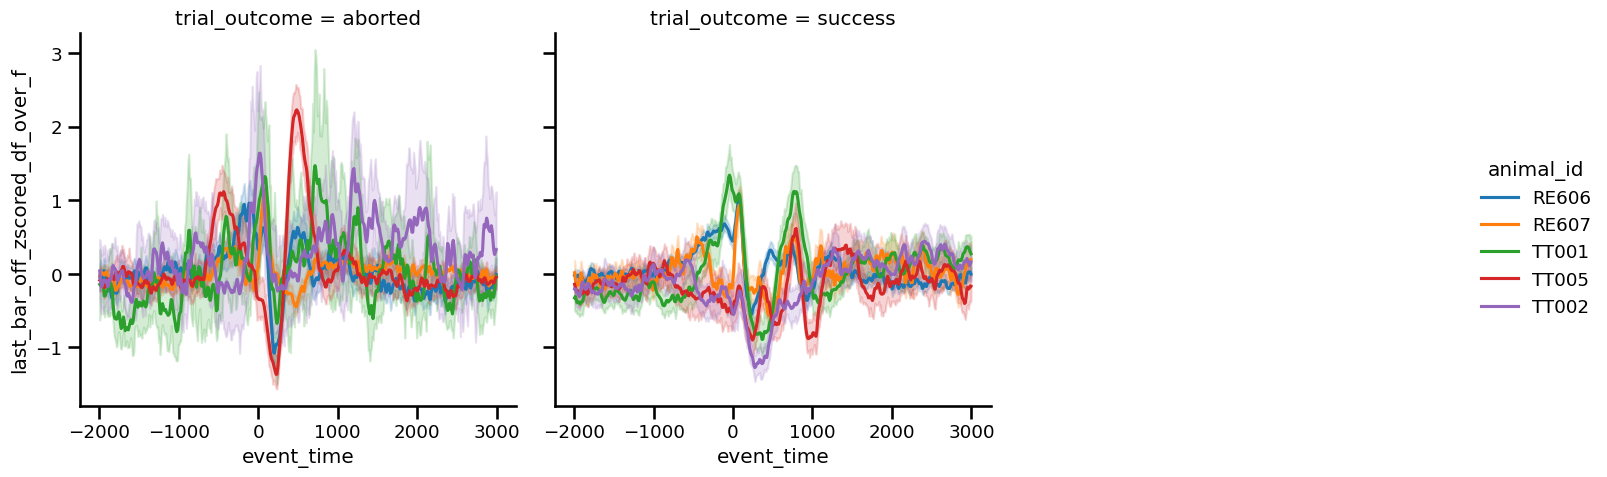

In [126]:
vars_to_plot = ['hold_for_water_zscored_df_over_f', 
                'first_bar_off_zscored_df_over_f',
                'first_spout_zscored_df_over_f',
                'last_bar_off_zscored_df_over_f']

for v in vars_to_plot:
    plot_subject_average(ds_combined, animal_id, v)